In [2]:
# basics
import os
import utilities.utils as utils
import numpy as np
from tqdm.notebook import tqdm 


# torch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import lightning as L


# custom modules
from data_acquisition import DataHandler


# Configure logging for the pipeline
logger = utils.setup_logger(level='ERROR')

In [13]:
cities = ["Wien", 'London', 'CapeTown', 'Hamburg', 'Johannesburg', 'London', 'Montreal', 'Paris', 'Seoul', 'Singapore', 'Sydney']


cities = [
    # "Wien",
    # "Muenchen",
    # "Soul",
    # "CapeTown",
    # "Paris",
    # "Singapore",
    # "Sidney",
    # "London",
    # "Montreal",
    # "Bogota",
    "Berlin" # downloads the specific bbox for testing
]

test_city = ["Berlin"]

datahandler = DataHandler(logger, path_to_data_directory="data")
datahandler.openeo_temporal_extent=["2023-03-01", "2023-10-31"]

In [8]:
# datahandler.connect_to_openeo()
datahandler.get_jobs()
# datahandler.delete_jobs() # delete all previous jobs

[{'created': '2024-07-07T16:57:28Z',
  'id': 'j-240707953fde45668e2f08b6e57b3061',
  'status': 'error',
  'updated': '2024-07-07T22:47:07Z'},
 {'created': '2024-07-07T19:39:24Z',
  'id': 'j-24070711e62b4b698d16072da8a9f100',
  'status': 'error',
  'updated': '2024-07-08T03:28:06Z'},
 {'created': '2024-07-08T13:36:52Z',
  'id': 'j-24070818be154d8f9eb2f8643fce7e6a',
  'status': 'running',
  'updated': '2024-07-08T13:54:16Z'}]

In [14]:
# load images and mask for all specified cites

import os


for city in tqdm(cities):
    buildings = None
    if not os.path.exists(os.path.join(datahandler.path_to_data_directory,city,'building_mask_dense.tif')):
        print("loading local buildings")
        buildings = datahandler.get_buildings(city)
    image = datahandler.get_satellite_image(city).transpose(1,2,0)
    sparse_mask = datahandler.get_building_mask(city, all_touched=False, loaded_buildings=buildings)
    dense_mask = datahandler.get_building_mask(city, all_touched=True, loaded_buildings=buildings)
    boundary_mask = datahandler.get_boundaries_mask(city)



  0%|          | 0/1 [00:00<?, ?it/s]

loading local buildings


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

Display of the last Image (Berlin the Test Data)

Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4649, 'height': 3851, 'count': 6, 'crs': CRS.from_epsg(32633), 'transform': Affine(10.0, 0.0, 369760.0,
       0.0, -10.0, 5837890.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
SHAPE:		 (3851, 4649)
dtype		 int16
max		 10608
min		 -32768
mean		 537.4003168913171
std		 1863.0149277547941
sum		 9621238556
Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4649, 'height': 3851, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(10.0, 0.0, 369760.0,
       0.0, -10.0, 5837890.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
SHAPE:		 (3851, 4649)
dtype		 int16
max		 0
min		 0
mean		 0.0
std		 0.0
sum		 0
Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4649, 'height': 3851, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(10.0, 0.0, 369760.0,
       0.0, -10.0, 5837890.0),

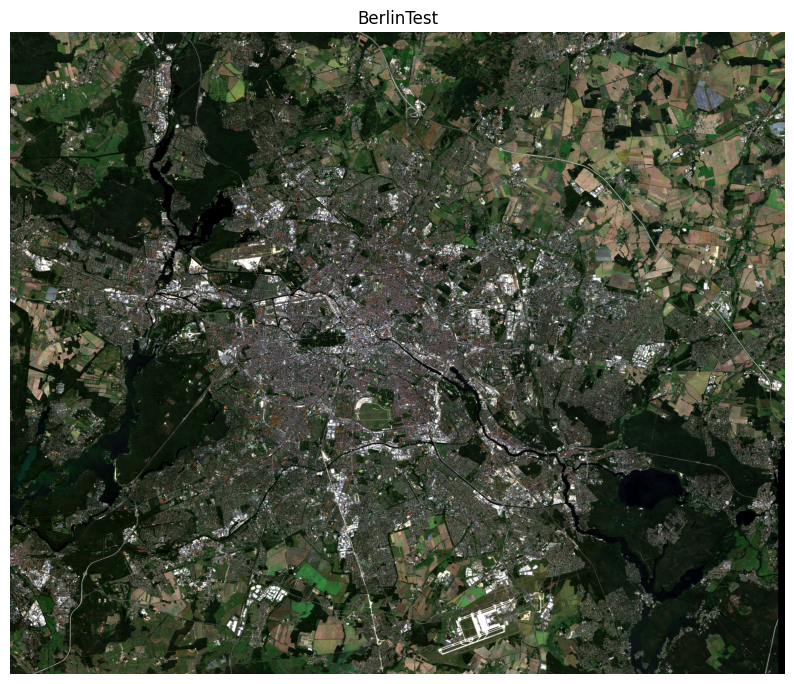

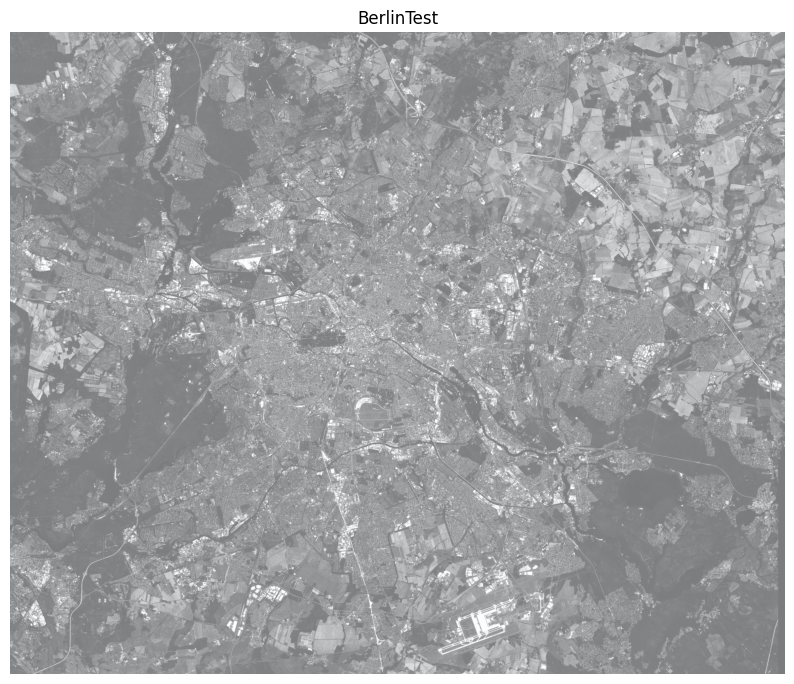

In [15]:
from utilities.plot_utils import (plot_band_with_mask, 
                                  histogram_scaler_bands, 
                                  describe_tif, 
                                  plot_bands)

import rasterio
with rasterio.open("./data/Berlin/openEO.tif") as src:
    describe_tif(src)
    image = src.read([1,2,3,4,5,6])
with rasterio.open("./data/Berlin/building_mask_dense.tif") as src:
    describe_tif(src)
    dense_mask = src.read(1)
with rasterio.open("./data/Berlin/boundaries_mask.tif") as src:
    describe_tif(src)
    boundary_mask = src.read(1)


# for better understanding, what the data bands are -> the dict
b = {
    "B04": 0,
    "B03": 1,
    "B02": 2,
    "B08": 3,
    "B12": 4,
    "B11": 5,
}

image =  histogram_scaler_bands(image, 1.0, 99.0)

plot_bands(image, bands=[b["B04"], b["B03"], b["B02"]], title="BerlinTest")
plot_band_with_mask(image[b["B04"]], dense_mask, title="BerlinTest")
# plot_band_with_mask(image[b["B04"]], boundary_mask, cmap_band="Blues",cmap_mask="Reds", title="BerlinTest")
# boundary_mask.shape

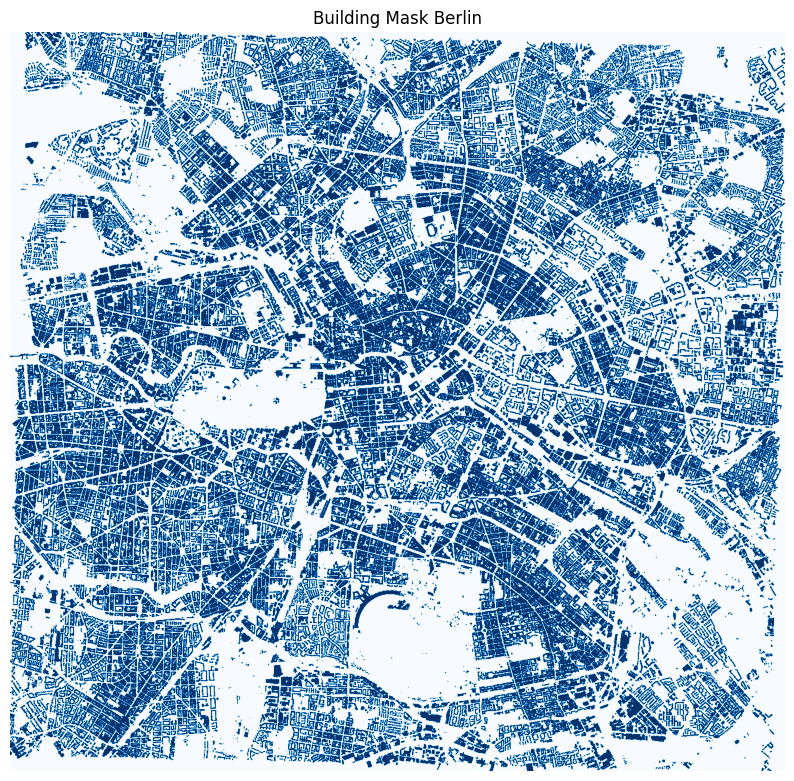

In [11]:
from utilities.plot_utils import plot_band

plot_band(dense_mask, title="Building Mask Berlin")